In [1]:
import math
import numpy as np
import random

np.random.seed(1337)
random.seed(1337)
np.set_printoptions(suppress=True)


class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op  # the op that produced this node, for graphviz / debugging / etc
    
    @classmethod
    def constant(cls, data):
        return cls(data, _op='constant')

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        
        def _backward():
            self.grad += other.data * out.grad
            if other._op != 'constant':
                other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)
                          ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    # fix dead neuron problem
    def leaky_relu(self):
        out = Value(self.data * 0.01 if self.data <
                    0 else self.data, (self,), 'ReLU')

        def _backward():
            local_grad = 1.0 if self.data > 0 else 0.01
            self.grad += local_grad * out.grad 
        out._backward = _backward
        return out

    def log(self):
    
        EPSILON = 1e-7
        clipped_data = max(EPSILON, self.data)
        
        out = Value(math.log(clipped_data), (self, ), 'log')

        def _backward():
            self.grad += (1 / clipped_data) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def sigmoid(self):
        x = self.data
        t = 1 / (1 + (math.exp(-x)))

        out = Value(t, (self, ), 'sigmoid')

        def _backward():
            self.grad += (out.data * (1 - out.data)) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __ge__(self, other):
        return self.data >= other.data

    def __le__(self, other):
        return self.data <= other.data

    def __gt__(self, other):
        return self.data > other.data

    def __lt__(self, other):
        return self.data < other.data

    def __neg__(self):  # -self
        return self * -1

    def __radd__(self, other):  # other + self
        return self + other

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __rtruediv__(self, other):  # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    


    

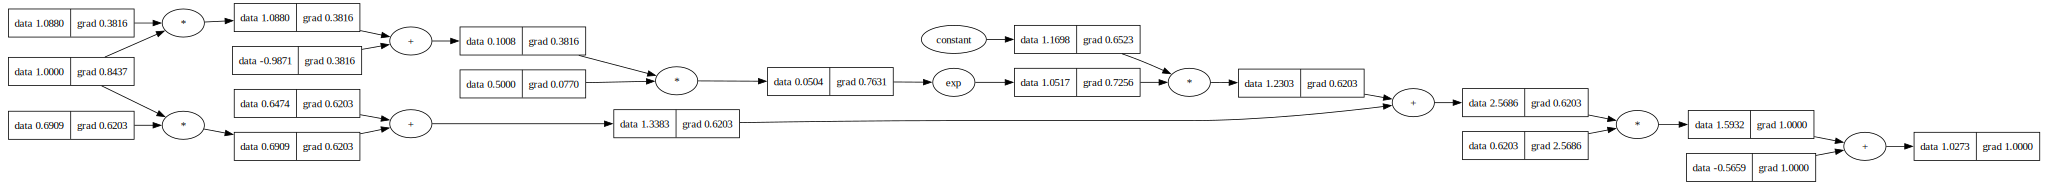

In [35]:
import random
import math


class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

    def layers(self):
        return []

    def summary(self):
        return f"{len(self.layers())} layers, {len(self.parameters())} parameters"


class Neuron(Module):

    # I want to introduce weight sharing, which means I need to be able to
    # initialise a neuron with pre defined weights, but leave the bias?

    def __init__(self, nin, nonlin=True, **kwargs):
        k = math.sqrt(2 / nin)
        
        
        # Initialize weights using a uniform distribution in the range [-k, k]
        self.w = [Value(random.uniform(-k, k)) for _ in range(nin)]
        self.b = Value(random.uniform(-k, k))
        self.nonlin = nonlin
        self.activate = kwargs.get('activate', None)

    def __call__(self, x):
        if isinstance(x, (Value, float, int)):
            # This is for a single input, likely at the start of a layer
            act = (self.w[0] * x) + self.b
        else:
            act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        if self.activate and self.nonlin == False:
            return self.activate(act)
        else:
            return act.leaky_relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b] if isinstance(self.w[0], Value) else [p for w_list in self.w for p in w_list] + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else '{self.activate}'}Neuron({len(self.w)})"


class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]
            
    def __call__(self, x):
            # Standard layer behavior
        out = [n(x) for n in self.neurons]
        return out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
        
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):
    def __init__(self, nin, nouts, tied_weights_from=None, **kwargs):
        sz = [nin] + nouts
        self.layers = []
        if tied_weights_from is None:
            # Standard MLP initialization
            self.layers = [Layer(sz[i], sz[i+1], nonlin=i != len(nouts)-1, **kwargs) for i in range(len(nouts))]
            
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

class AutoEncoder(Module):
    def __init__(self, in_embeds=1, hidden_layers=[], latent_dim=1, act_func=None):
        self.latent_dim = latent_dim
        self.act_func = act_func
        self.encoder = MLP(in_embeds, hidden_layers + [latent_dim])
        self.decoder = MLP(latent_dim, list(reversed(hidden_layers)) + [in_embeds], activate=act_func)
    
    
    def __call__(self, x):
        compressed = self.encoder(x)
        out = self.decoder(compressed)
        return out

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded
    
    def decode(self, x):
        decoded = self.decoder(x)
        return decoded

    def parameters(self):
        return self.encoder.parameters() + self.decoder.parameters()

    def layers(self):
        return self.encoder.layers + self.decoder.layers

    def pretty(self):
        if self.act_func != None:
            hey = str(self.act_func)
            return hey.split()[1][6:]
        else:
            return "no function"

    def __repr__(self):
        return f"encoder has {len(self.encoder.layers)}, decoder has {len(self.decoder.layers)}, latent dim is {self.latent_dim} activated with {self.pretty()}"


class VariationalAutoEncoder(Module):
    
    
    def __init__(self, in_embeds=1, hidden_layers=[], latent_dim=1, act_func=None):
        self.latent_dim = latent_dim
        self.act_func = act_func
        
        # Encoder outputs 2 * latent_dim: mean and log-variance for each dimension
        # Last layer outputs 2*latent_dim (no activation on this layer)
        self.encoder = MLP(in_embeds, hidden_layers + [2 * latent_dim])
        self.decoder = MLP(latent_dim, list(reversed(hidden_layers)) + [in_embeds], activate=act_func)
    
    def encode(self, x):
        """Encode input to mean and log-variance"""
        encoded = self.encoder(x)
        
        # Ensure encoded is a list
        if not isinstance(encoded, list):
            encoded = [encoded]
        
        # Split the output into mean and log_var
        # encoded should be a list of 2*latent_dim values
        if len(encoded) != 2 * self.latent_dim:
            raise ValueError(f"Encoder output dimension {len(encoded)} doesn't match expected 2*latent_dim={2*self.latent_dim}")
        
        mu = encoded[:self.latent_dim]
        log_var = encoded[self.latent_dim:]
        
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick: z = mu + sigma * epsilon
        where epsilon ~ N(0,1) and sigma = exp(0.5 * log_var)
        
        Note: epsilon is sampled and treated as a constant during backprop
        """
        # Sample epsilon from standard normal (treated as constant in backprop)
        # Using Value.constant() ensures gradients don't flow to epsilon
        epsilon = [Value.constant(random.gauss(0, 1)) for _ in range(len(mu))]
        
        # Compute sigma = exp(0.5 * log_var) more efficiently
        # sigma = exp(0.5 * log_var) = sqrt(exp(log_var))
        sigma = [(log_var_i * 0.5).exp() for log_var_i in log_var]
        
        # z = mu + sigma * epsilon
        z = [mu_i + sigma_i * eps_i for mu_i, sigma_i, eps_i in zip(mu, sigma, epsilon)]
        
        return z
    
    def decode(self, z):
        """Decode latent sample to reconstruction"""
        return self.decoder(z)
    
    def __call__(self, x):
        """Forward pass: encode, sample, decode"""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var
    
    def parameters(self):
        return self.encoder.parameters() + self.decoder.parameters()
    
    
    def layers(self):
        return self.encoder.layers + self.decoder.layers
    
    def __repr__(self):
        return f"VAE(encoder: {len(self.encoder.layers)} layers, decoder: {len(self.decoder.layers)} layers, latent_dim: {self.latent_dim})"


from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot




In [3]:
class Optimizer:
    """Base class for optimizers"""

    def __init__(self, parameters):
        self.parameters = parameters
    
    def zero_grad(self):
        for p in self.parameters:
            p.grad = 0

  
    def step(self):
        """Take a step of gradient descent"""

        raise NotImplementedError


class SGD(Optimizer):
    """Stochastic Gradient Descent optimizer"""

    def __init__(self, parameters, learning_rate = 0.01):
        super().__init__(parameters)
        self.learning_rate = learning_rate

    def step(self):
        for p in self.parameters:
            p.data -= self.learning_rate * p.grad
            
def mean_squared_error(y_true, y_pred):
    total_loss = sum([(true - pred)**2 for true, pred in zip(y_true, y_pred)])

    
    return total_loss


def vae_loss(reconstruction, target, mu, log_var, beta=1.0):
    """
    Variational Autoencoder loss = Reconstruction Loss + beta * KL Divergence
    
    Args:
        reconstruction: Value or List of Value objects (reconstructed output)
        target: List of Value objects (original input)
        mu: List of Value objects (mean of latent distribution)
        log_var: List of Value objects (log variance of latent distribution)
        beta: Weight for KL divergence term (default 1.0)
    
    Returns:
        Total VAE loss as a Value object
    """
    # Ensure reconstruction is a list
    if not isinstance(reconstruction, list):
        reconstruction = [reconstruction]
    if not isinstance(target, list):
        target = [target]
    
    # Reconstruction loss (MSE)
    recon_loss = mean_squared_error(target, reconstruction)
    
    # KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    # This encourages the latent distribution to be close to N(0,1)
    kl_terms = []
    for mu_i, log_var_i in zip(mu, log_var):
        # KL term for one dimension: -0.5 * (1 + log_var - mu^2 - exp(log_var))
        kl_term = -0.5 * (Value(1.0) + log_var_i - mu_i**2 - log_var_i.exp())
        kl_terms.append(kl_term)
    
    kl_loss = sum(kl_terms) if kl_terms else Value(0.0)
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss


    

Iteration 0, VAE Loss: 2.463476246431
Iteration 10, VAE Loss: 0.910699696125
Iteration 20, VAE Loss: 1.059092680655
Iteration 30, VAE Loss: 0.850791852062
Iteration 40, VAE Loss: 0.691623180016
Iteration 50, VAE Loss: 1.042608673999
Iteration 60, VAE Loss: 0.447985508475
Iteration 70, VAE Loss: 0.180016259229
Iteration 80, VAE Loss: 0.446703238289
Iteration 90, VAE Loss: 0.150772434850
Iteration 100, VAE Loss: 0.095977532512
Iteration 110, VAE Loss: 0.277702428618
Iteration 120, VAE Loss: 0.219999625126
Iteration 130, VAE Loss: 0.133044929157
Iteration 140, VAE Loss: 0.050083730404
Iteration 150, VAE Loss: 0.051161866782
Iteration 160, VAE Loss: 0.046513299873
Iteration 170, VAE Loss: 0.048219043463
Iteration 180, VAE Loss: 0.198533861304
Iteration 190, VAE Loss: 0.053457095102
Iteration 200, VAE Loss: 0.030638223698
Iteration 210, VAE Loss: 0.106809920863
Iteration 220, VAE Loss: 0.113939861879
Iteration 230, VAE Loss: 0.044036973052
Iteration 240, VAE Loss: 0.041529918750
Iteration 2

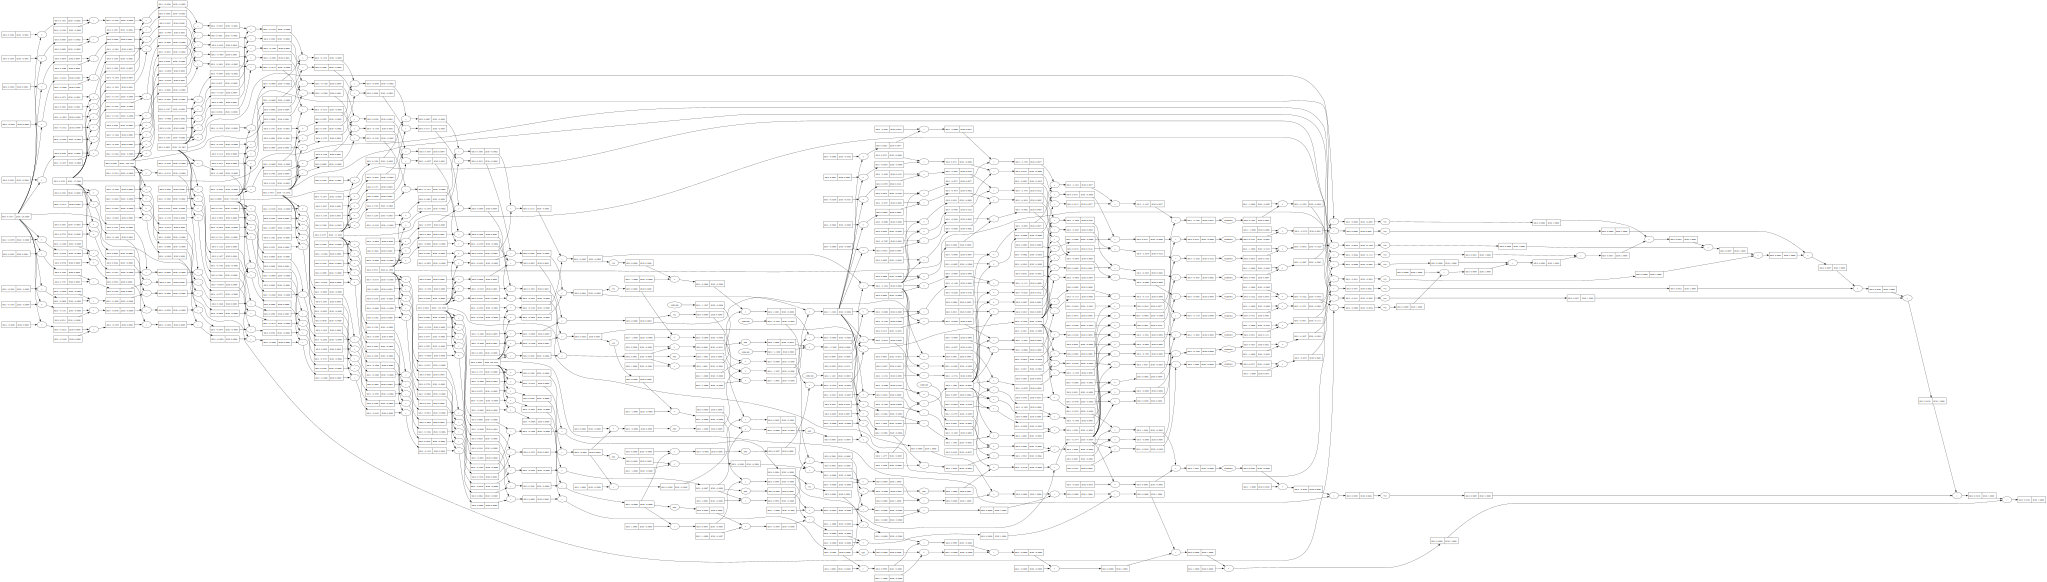

In [36]:
vae = VariationalAutoEncoder(
    in_embeds=10,        # Input dimension  # Number of hidden layers
    latent_dim=5,        # Latent space dimension
    act_func=Value.sigmoid     # Activation function (None uses default leaky_relu)
)

x = [Value(random.uniform(0, 1)) for _ in range(10)]

target = x

optimizer = SGD(vae.parameters(), learning_rate=0.1)

# Example input (list of Values)

for i in range(500):
    optimizer.zero_grad()
    # Forward pass returns: (reconstruction, mu, log_var)
    reconstruction, mu, log_var = vae(x)

    # Ensure reconstruction is a list for loss computation
    if not isinstance(reconstruction, list):
        reconstruction = [reconstruction]

    # Compute VAE loss
     # Target is the input itself (autoencoder)
    loss = vae_loss(reconstruction, target, mu, log_var)

    # Backward pass
    loss.backward() 

    
    optimizer.step()

    
    if i % 10 == 0:
        print(f"Iteration {i}, VAE Loss: {loss.data:.12f}")


draw_dot(loss)



In [5]:
import random

class BatchIterator:
    """Iterates on data by batches"""

    def __init__(self,inputs,targets,batch_size=32):
        self.inputs  = inputs
        self.targets = targets
        self.batch_size = batch_size

    def __call__(self):
        starts = list(range(0, len(self.inputs), self.batch_size))
            
        for start in starts:
            end = start + self.batch_size
            batch_inputs = self.inputs[start:end]
            batch_targets = self.targets[start:end]
            yield (batch_inputs, batch_targets)

In [6]:
def mean_squared_error(y_true, y_pred):
    total_loss = sum([(true - pred)**2 for true, pred in zip(y_true, y_pred)])

    
    return total_loss


def vae_loss(reconstruction, target, mu, log_var, beta=1.0):
    """
    Variational Autoencoder loss = Reconstruction Loss + beta * KL Divergence
    
    Args:
        reconstruction: Value or List of Value objects (reconstructed output)
        target: List of Value objects (original input)
        mu: List of Value objects (mean of latent distribution)
        log_var: List of Value objects (log variance of latent distribution)
        beta: Weight for KL divergence term (default 1.0)
    
    Returns:
        Total VAE loss as a Value object
    """
    # Ensure reconstruction is a list
    if not isinstance(reconstruction, list):
        reconstruction = [reconstruction]
    if not isinstance(target, list):
        target = [target]
    
    # Reconstruction loss (MSE)
    recon_loss = mean_squared_error(target, reconstruction)
    
    # KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    # This encourages the latent distribution to be close to N(0,1)
    kl_terms = []
    for mu_i, log_var_i in zip(mu, log_var):
        # KL term for one dimension: -0.5 * (1 + log_var - mu^2 - exp(log_var))
        kl_term = -0.5 * (Value(1.0) + log_var_i - mu_i**2 - log_var_i.exp())
        kl_terms.append(kl_term)
    
    kl_loss = sum(kl_terms) if kl_terms else Value(0.0)
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss


    


In [7]:
 # from pyfit.engine import Vector, Scalar
# from pyfit.nn import Module
# from pyfit.optim import Optimizer
# from pyfit.data import BatchIterator
# from pyfit.metrics import binary_accuracy

# Used to record training history for metrics
History = {}


class Trainer:
    """Encapsulates the model training loop"""

    def __init__(self, model, optimizer, loss):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss

    def fit(self, data_iterator, num_epochs=500, verbose=False):
        """Fits the model to the data"""

        history = {"loss": []}
        epoch_loss = 0
        epoch_y_true = []
        epoch_y_pred = []
        for epoch in range(num_epochs):
            # Reset epoch data
            epoch_loss = 0
            epoch_y_true = []
            epoch_y_pred = []

            for batch in data_iterator():
                self.optimizer.zero_grad()
                # Forward pass
                outputs = list(map(self.model, batch[0]))
                
                # Loss computation
                batch_y_pred = [item for sublist in outputs for item in sublist]
                batch_y_true = [item for sublist in batch[1] for item in sublist]
                
                batch_loss = self.loss(batch_y_true, batch_y_pred)
                epoch_loss += batch_loss.data
                # Store batch predictions and ground truth for computing epoch metrics
                epoch_y_pred.extend(batch_y_pred)
                epoch_y_true.extend(batch_y_true)

                # Backprop and gradient descent
                batch_loss.backward()
                self.optimizer.step()

            # Accuracy computation for epoch
            
            

            # Record training history
            history["loss"].append(epoch_loss)
            if verbose:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], "
                    f"loss: {epoch_loss:.6f}, "
                )

        return history
    


In [8]:
x = [
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
]
target = x

In [9]:
auto = AutoEncoder(
    in_embeds=5,# Input dimension   # Number of hidden layers
    latent_dim=3,
    act_func=Value.sigmoid
)

In [10]:
optimizer = SGD(auto.parameters(), learning_rate=0.5)
data_iterator = BatchIterator(x, target, batch_size=5)
trainer = Trainer(auto, optimizer, loss=mean_squared_error)

history = trainer.fit(data_iterator, num_epochs=2000, verbose=True)

Epoch [1/2000], loss: 6.343172, 
Epoch [2/2000], loss: 4.225269, 
Epoch [3/2000], loss: 3.587742, 
Epoch [4/2000], loss: 3.224606, 
Epoch [5/2000], loss: 2.910034, 
Epoch [6/2000], loss: 2.604575, 
Epoch [7/2000], loss: 2.318862, 
Epoch [8/2000], loss: 2.068605, 
Epoch [9/2000], loss: 1.855993, 
Epoch [10/2000], loss: 1.671790, 
Epoch [11/2000], loss: 1.505269, 
Epoch [12/2000], loss: 1.349487, 
Epoch [13/2000], loss: 1.201685, 
Epoch [14/2000], loss: 1.062068, 
Epoch [15/2000], loss: 0.932674, 
Epoch [16/2000], loss: 0.816224, 
Epoch [17/2000], loss: 0.714733, 
Epoch [18/2000], loss: 0.628583, 
Epoch [19/2000], loss: 0.556612, 
Epoch [20/2000], loss: 0.496833, 
Epoch [21/2000], loss: 0.447094, 
Epoch [22/2000], loss: 0.405438, 
Epoch [23/2000], loss: 0.370242, 
Epoch [24/2000], loss: 0.340213, 
Epoch [25/2000], loss: 0.314347, 
Epoch [26/2000], loss: 0.291864, 
Epoch [27/2000], loss: 0.272160, 
Epoch [28/2000], loss: 0.254763, 
Epoch [29/2000], loss: 0.239300, 
Epoch [30/2000], loss: 

Epoch [41/2000], loss: 0.135072, 
Epoch [42/2000], loss: 0.130125, 
Epoch [43/2000], loss: 0.125501, 
Epoch [44/2000], loss: 0.121172, 
Epoch [45/2000], loss: 0.117110, 
Epoch [46/2000], loss: 0.113292, 
Epoch [47/2000], loss: 0.109698, 
Epoch [48/2000], loss: 0.106309, 
Epoch [49/2000], loss: 0.103109, 
Epoch [50/2000], loss: 0.100083, 
Epoch [51/2000], loss: 0.097217, 
Epoch [52/2000], loss: 0.094500, 
Epoch [53/2000], loss: 0.091920, 
Epoch [54/2000], loss: 0.089469, 
Epoch [55/2000], loss: 0.087136, 
Epoch [56/2000], loss: 0.084913, 
Epoch [57/2000], loss: 0.082794, 
Epoch [58/2000], loss: 0.080772, 
Epoch [59/2000], loss: 0.078839, 
Epoch [60/2000], loss: 0.076991, 
Epoch [61/2000], loss: 0.075223, 
Epoch [62/2000], loss: 0.073528, 
Epoch [63/2000], loss: 0.071904, 
Epoch [64/2000], loss: 0.070345, 
Epoch [65/2000], loss: 0.068849, 
Epoch [66/2000], loss: 0.067411, 
Epoch [67/2000], loss: 0.066028, 
Epoch [68/2000], loss: 0.064698, 
Epoch [69/2000], loss: 0.063417, 
Epoch [70/2000

In [11]:
for i in range(len(x[0])):
    for j in range(len(x)):
        print(f"expected {x[j][i]}, result, {auto(x[j])[i].data}")
    print("--------------------------------")

expected 1, result, 0.9943062652089871
expected 0, result, 0.006147608124679025
expected 0, result, 0.010578945969371848
expected 0, result, 1.4171247013068295e-06
expected 0, result, 0.01286625932622884
--------------------------------
expected 0, result, 0.009538885289336886
expected 1, result, 0.9929678471980102
expected 0, result, 2.2010030671547117e-05
expected 0, result, 0.010741830203299413
expected 0, result, 0.01221719070912356
--------------------------------
expected 0, result, 0.007182649875901055
expected 0, result, 8.586167635448348e-10
expected 1, result, 0.995294634447513
expected 0, result, 0.008102710187792992
expected 0, result, 0.008917055707779254
--------------------------------
expected 0, result, 9.75344607479486e-08
expected 0, result, 0.005631745213211774
expected 0, result, 0.009778938159587917
expected 1, result, 0.9950685766326679
expected 0, result, 0.011899868307144542
--------------------------------
expected 0, result, 0.0026770351219864
expected 0, res

In [12]:
vae = VariationalAutoEncoder(
    in_embeds=10,        # Input dimension  # Number of hidden layers
    latent_dim=5,        # Latent space dimension
    act_func=Value.sigmoid     # Activation function (None uses default leaky_relu)
)

x = [Value(random.uniform(0, 1)) for _ in range(10)]

target = x

In [13]:
optimizer = SGD(vae.parameters(), learning_rate=0.1)

# Example input (list of Values)

for i in range(250):
    optimizer.zero_grad()
    # Forward pass returns: (reconstruction, mu, log_var)
    reconstruction, mu, log_var = vae(x)

    # Ensure reconstruction is a list for loss computation
    if not isinstance(reconstruction, list):
        reconstruction = [reconstruction]

    # Compute VAE loss
     # Target is the input itself (autoencoder)
    loss = vae_loss(reconstruction, target, mu, log_var, beta=1.0)

    # Backward pass
    loss.backward() 

    
    optimizer.step()

    
    if i % 10 == 0:
        print(f"Iteration {i}, VAE Loss: {loss.data:.12f}")




Iteration 0, VAE Loss: 2.734234079369
Iteration 10, VAE Loss: 2.781424013785
Iteration 20, VAE Loss: 1.810239699137
Iteration 30, VAE Loss: 2.174800844702
Iteration 40, VAE Loss: 2.519782502978
Iteration 50, VAE Loss: 2.853945043131
Iteration 60, VAE Loss: 2.668678472347
Iteration 70, VAE Loss: 2.791415043219
Iteration 80, VAE Loss: 2.467595954934
Iteration 90, VAE Loss: 2.503641055728
Iteration 100, VAE Loss: 2.334440056567
Iteration 110, VAE Loss: 3.037170746719
Iteration 120, VAE Loss: 2.250452557605
Iteration 130, VAE Loss: 2.454153830034
Iteration 140, VAE Loss: 2.588616850818
Iteration 150, VAE Loss: 2.720581455482
Iteration 160, VAE Loss: 2.128345834084
Iteration 170, VAE Loss: 2.327611671716
Iteration 180, VAE Loss: 2.129896068764
Iteration 190, VAE Loss: 2.472808997124
Iteration 200, VAE Loss: 1.992719851023
Iteration 210, VAE Loss: 2.327595562900
Iteration 220, VAE Loss: 2.643022956249
Iteration 230, VAE Loss: 2.794462686539
Iteration 240, VAE Loss: 2.878890250260


In [14]:
# from graphviz import Digraph

# def trace(root):
#     nodes, edges = set(), set()
#     def build(v):
#         if v not in nodes:
#             nodes.add(v)
#             for child in v._prev:
#                 edges.add((child, v))
#                 build(child)
#     build(root)
#     return nodes, edges

# def draw_dot(root, format='svg', rankdir='LR'):
#     """
#     format: png | svg | ...
#     rankdir: TB (top to bottom graph) | LR (left to right)
#     """
#     assert rankdir in ['LR', 'TB']
#     nodes, edges = trace(root)
#     dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
#     for n in nodes:
#         dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
#         if n._op:
#             dot.node(name=str(id(n)) + n._op, label=n._op)
#             dot.edge(str(id(n)) + n._op, str(id(n)))
    
#     for n1, n2 in edges:
#         dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
#     return dot

In [15]:
# draw_dot(reconstruction[0])

In [16]:

# # Example usage of VariationalAutoEncoder

# # Create a simple VAE
# auto = AutoEncoder(
#     in_embeds=10,        # Input dimension
#     hidden_layers=[6],   # Number of hidden layers
#     latent_dim=3,        # Latent space dimension
#     act_func=Value.sigmoid,       # Activation function (None uses default leaky_relu)
#     tied=True           # Whether to use tied weights
# )

# optimizer = SGD(auto.parameters())

# # Example input (list of Values)
# x = [Value(random.uniform(0, 1)) for _ in range(10)]
# target = [Value(val.data) for val in x]  # Target is the input itself (autoencoder)
# for i in range(400):
#     optimizer.zero_grad()
    
#     # Forward pass returns: (reconstruction, mu, log_var)
#     reconstruction = auto(x)

#     # Ensure reconstruction is a list for loss computation

#     # Compute VAE loss
    
#     loss = mean_squared_error(reconstruction, target)

#     # Backward pass
#     loss.backward()
    
#     optimizer.step()

#     print(f"AutoEncoder Loss: {loss.data:.12f}")


# # Note: To use VAE with the Trainer class, you'll need to create a wrapper
# # or modify the training loop to handle the (reconstruction, mu, log_var) output
# # and use vae_loss instead of the standard MSE loss.


In [17]:
# print([j.data for j in x])
# print([i.data for i in reconstruction])



In [18]:
# from sklearn.datasets import load_digits
# from sklearn.preprocessing import MinMaxScaler

In [19]:
# X, y = load_digits(return_X_y=True)
# t = MinMaxScaler()
# t.fit(X)
# X_train = t.transform(X)

In [20]:

# # Example usage of VariationalAutoEncoder

# # Create a simple VAE
# auto = AutoEncoder(
#     in_embeds=64,        # Input dimension
#     n_hidden_layers=1,   # Number of hidden layers
#     compressed=16,        # Latent space dimension
#     act_func=Value.sigmoid,       # Activation function (None uses default leaky_relu)
#     tied=True           # Whether to use tied weights
# )

# optimizer = SGD(auto.parameters())

# # Example input (list of Values)
# target = X_train[0]
# target = list(map(Value, target)) # Target is the input itself (autoencoder)
# for i in range(150):
#     optimizer.zero_grad()
    
#     # Forward pass returns: (reconstruction, mu, log_var)
    
#     # reconstruction = [list(map(Value, xrow)) for xrow in X_train]
    
#     reconstruction = map(Value, X_train[0])
    
#     scores = auto(reconstruction)
#     # Ensure reconstruction is a list for loss computation

#     # Compute VAE loss
    
#     loss = mean_squared_error(target, scores)

#     # Backward pass
#     loss.backward()
    
#     optimizer.step()

#     print(f"Iteration : {i}, AutoEncoder Loss: {total_loss.data:.12f}")
#     print(auto.parameters()[:30])


# # Note: To use VAE with the Trainer class, you'll need to create a wrapper
# # or modify the training loop to handle the (reconstruction, mu, log_var) output
# # and use vae_loss instead of the standard MSE loss.


In [21]:
# X = load_digits()

# mean = sum(sum(X.data)) / (len(X.data) * 64)

# std = (sum(sum((X.data - mean)**2)) / (len(X.data) * 64))**0.5

# def standardize_transform(x):
#     """
#     Standardizes a given tensor using the precomputed MNIST mean and standard deviation.

#     Args:
#         x: Input tensor to standardize.

#     Returns:
#         Standardized tensor.
#     """
#     return (x - mean) / std

# def standardize_inverse(x):
#     """
#     Reverses the standardization on a tensor using the precomputed MNIST mean and standard deviation.

#     Args:
#         x: Input tensor to de-standardize.

#     Returns:
#         De-standardized tensor.
#     """
#     return x * std + mean


In [22]:
# auto = AutoEncoder(in_embeds=64, hidden_layers=[32], latent_dim=8, act_func=Value.sigmoid, tied=False) 
# optimizer = SGD(auto.parameters(), learning_rate=0.5)

# train = X_train_values[:10]
# target = target_values[:10]
# historical_loss = []
# for i in range(500):
#     optimizer.zero_grad()
    
    
#     # reconstruction = map(Value, single_test)
    
#     # score = auto(reconstruction)
    
#     scores_values = [auto(x) for x in train]
    
#     # loss = mean_squared_error(target, score)
    
#     loss = sum([mean_squared_error(targ, pred) for targ, pred in zip(target, scores_values)])
#     historical_loss.append(loss)
    
#     loss.backward()
    
#     optimizer.step()

#     print(f"Iteration : {i}, AutoEncoder Loss: {loss.data:.12f}")




In [23]:
# def visualize_micrograd_latent_space(model, data, targets):
#     """
#     Displays the distribution of data in the Autoencoder's latent space 
#     using the first two dimensions of Z, colored by target labels.
    
#     Args:
#         model: The trained micrograd autoencoder model with an .encode() method.
#         data: The input data (numpy array) to process.
#         targets: The labels/targets for coloring the points.
#     """
#     # Note: micrograd models don't typically have a formal .eval() mode, 
#     # but the forward pass for inference is the same.
    
#     latent_vectors = []
#     labels = []
#     COLORS = ['red', 'blue', 'green', 'yellow', 'orange', 'cyan', 'gray', 'black', 'purple', 'pink']

#     for i in range(len(data)):
#         img_data = data[i]
#         label = targets[i]
        
#         # Convert numpy array row to a list of micrograd Value objects
#         img_values = list(map(Value, img_data))
        
#         # Get the latent representation (requires model.encode() method)
#         z_values = model.encode(img_values)
        
#         # Convert micrograd Values to a numpy array of floats
#         z_numpy = np.array([v.data for v in z_values])
        
#         latent_vectors.append(z_numpy)
#         labels.append(label)

#     latent_vectors = np.array(latent_vectors)
#     labels = np.array(labels)

#     plt.figure(figsize=(12, 8))
    
#     unique_labels = sorted(list(set(labels)))
    
#     for i, label in enumerate(unique_labels):
#         indices = np.where(labels == label)
#         z_points = latent_vectors[indices]
        
#         # Plot the first two dimensions (Z1 vs Z2)
#         if z_points.shape[1] >= 2:
#             plt.scatter(
#                 z_points[:, 0], 
#                 z_points[:, 1], 
#                 color=COLORS[i % len(COLORS)], 
#                 label=str(label), 
#                 alpha=0.7
#             )
#         else:
#             print(f"Cannot visualize latent space: latent_dim is {z_points.shape[1]}, need at least 2 dimensions to plot Z1 vs Z2.")
#             return

#     plt.legend()
#     plt.title('Micrograd AutoEncoder Latent Space Distribution (Z1 vs Z2)')
#     plt.xlabel('Z1')
#     plt.ylabel('Z2')
#     plt.show()

In [24]:
# visualize_micrograd_latent_space(
#     model=auto,
#     data=multi_test,       # Use the scaled data
#     targets=X.images[:10]    # Use the actual digit labels for coloring
# )

In [25]:
# from sklearn.datasets import make_regression 
# from sklearn.model_selection import train_test_split


In [26]:
# X, y = make_regression(n_samples=100, n_features=30, n_informative=3, noise=0.1, random_state=42)

# print(X[1], y[1]) 

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) 

# t = MinMaxScaler() 

# t.fit(X_train) 

# X_train = t.transform(X_train) 

# X_test = t.transform(X_test) 

# X_train_values = [[Value(v) for v in sample] for sample in X_train]

# target = X_train_values

In [28]:
# autoEncode = AutoEncoder(
#     in_embeds=30,        # Input dimension   # Number of hidden layers
#     latent_dim=3, 
#     act_func=Value.sigmoid, # Latent space dimension,       
#     tied=True           # Whether to use tied weights
# )

In [29]:
# optimizer = SGD(autoEncode.parameters(), learning_rate=0.1)

# historical_loss = []

# for i in range(100):
#     optimizer.zero_grad()
    
#     # Forward pass returns: (reconstruction, mu, log_var)

#     scores_values = [autoEncode(x) for x in X_train_values]
    
#     # loss = mean_squared_error(target, score)
    
#     loss = sum([mean_squared_error(targ, pred) for targ, pred in zip(target, scores_values)])
#     historical_loss.append(loss)

#     # Backward pass
#     loss.backward()
    
#     optimizer.step()

#     print(f"Iteration: {i}, AutoEncoder Loss: {loss.data:.12f}")